# TODO:
#### 1. Динамический выбор лучшей формулы улыбки на основании сравнения ошибок
#### 2. Построение улыбки на основании выбранной формулы
#### 3. Скалирование t

In [1]:
from datetime import datetime, date, time
from openpyxl import load_workbook
from scipy import optimize
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Option(object):
    '''
    '''
    def __init__(self, curr_date, contract, exp_date, tick_price, tick,
                 fut_contract, strike, call, w, theor_price, fut_price):
        
        self.curr_date = datetime.strptime(curr_date, '%Y-%m-%d %H:%M:%S.%f')
        self.contract = contract        
        self.exp_date = datetime.strptime(exp_date, '%Y-%m-%d %H:%M:%S.%f')
        self.tick_price = float(tick_price)
        self.tick = float(tick)
        self.fut_contract = fut_contract
        self.strike = float(strike)
        self.call = call == 'C'
        self.w = float(w)
        self.theor_price = float(theor_price)
        self.fut_price = fut_price
        self.x = np.log(self.strike / self.fut_price)
        self.t = (self.exp_date - self.curr_date).days  / 365.0
        

In [3]:
class OptionSeries(object):
    
    '''Главная цель данного класса -
    хранить объекты опционов, в виде 
    серии, т.е. опционов на один
    фьючерсный контракт
    '''
    
    def __init__(self, fut_contract, fut_price):
        self.fut_contract = fut_contract
        self.fut_price = float(fut_price)
        self.options = {}
        
    
    def add_option(self, option):
        self.options[option.contract] = option
        
   
    def get_strikes_vol(self):
        for option in self.options.values():
            yield option.strike, option.w[0], option.x
    
    def get_t_series(self):
        '''
        Возвращаем время до экспирации
        '''
        return next(iter(self.options.values())).t
    
                        
    def get_w0(self):
        for option in self.options.values():
            if option.strike == self.fut_price:
                return option.w[0]
        raise ValueError("There isnt option with a central strike")
        
    def get_w(self, x):
        '''
        Возвращаем w для заданной денежности
        '''
        
    
    def get_w_atm_opts(self):
        '''Возвращаем w(x+) и w(x-)
        '''
        right_atm_opt, left_atm_opt = self.get_atm_opts()
        return (right_atm_opt.w[0], left_atm_opt.w[0])

    
    def get_atm_opts(self):
        '''Возвращаем два опциона ATM
        (ближайших), справа и слева от
        центрального страйка  
        '''
        
        right_atm_opt = ''
        left_atm_opt = ''
        
        right_atm_diff = np.inf
        left_atm_diff = np.inf
        
        for option in self.options.values():
            atm_diff = abs(option.strike - self.fut_price)
            
            if option.strike > self.fut_price and atm_diff < right_atm_diff:
                right_atm_diff = atm_diff
                right_atm_opt = option
                
            if option.strike < self.fut_price and atm_diff < left_atm_diff:
                left_atm_diff = atm_diff
                left_atm_opt = option
                
        return (right_atm_opt, left_atm_opt)       
    
        

### Read File

In [ ]:
wb = load_workbook(filename=r'C:\Users\DolmatovKI\Desktop\WinPython-64bit-3.4.4.1\notebooks\Options Data\RTS-6.16_new.xlsx', 
                   data_only=True)
ws = wb['RTS-6.16 2016-06-10']
ws = list(ws)[1:] # remove header

In [ ]:
options = {}

for index, row in enumerate(ws):
    option = Option(curr_date = row[0].value,
                    contract = row[1].value, 
                    exp_date = row[2].value,
                    tick_price = row[3].value,
                    tick = row[4].value,
                    fut_contract = row[5].value,
                    strike = row[6].value,
                    call = row[7].value,                        
                    volat = row[8].value,
                    theor_price = row[9].value,
                    fut_price = row[10].value)
    
        
    options[row[1].value] = option                                             
       
   

### Make Options Series

In [ ]:
options_series = {}

for option in options.values():
    if option.fut_contract not in options_series:
        options_series[option.fut_contract] = OptionSeries(option.fut_contract)          
    options_series[option.fut_contract].add_option(option)

### Callibration Functions

In [ ]:
def svi_func(p, K):
    '''
    p[0] = a
    p[1] = b
    p[2] = ro
    p[3] = m
    p[4] = sigma
    k = ln(K/F)    
    '''
    output = []
    for k in K:
        res = np.sqrt(p[0] + p[1]*(p[2]*(k - p[3]) + np.sqrt((k - p[3])**2 + p[4]**2)))
        output.append(res)
        
    return output



def err_func(p, K, y):
    return (svi_func(p, K) - y)

In [ ]:
def svi_func_err(parameters, *data):
    '''
    SVI func with built-in Error Func
    
    p[0] = a
    p[1] = b
    p[2] = ro
    p[3] = m
    p[4] = sigma
    k = ln(K/F)    
    '''
    
    a, b, ro, m, sigma = parameters
    x, y = data
    
    res = 0
    
    for i in range(len(x)):
        res += (np.sqrt(a + b*(ro*(x[i] - m) + np.sqrt((x[i] - m)**2.0 + sigma**2))) - y[i])**2
    
    return res**0.5

### Validation SVI Func

In [ ]:
par = np.array([5.0, 10.0, -10.0, 10.0, 50.0])

In [ ]:
add_strikes = np.arange(1, 100, 0.1)
add_strikes_ln = np.log(add_strikes / 49.0)

In [ ]:
y_values_new_test = svi_func(par, add_strikes_ln)
y_values_new_test = np.array(y_values_new_test)   

In [ ]:
plt.plot(add_strikes, y_values_new_test, 'ro')

---

## SVI Real Data

### Get a glimpse of our data

In [ ]:
strikes_values = []
x_values = []
y_values = []
for strike, volat, x in options_series['BR-8.16'].get_strikes_vol():
    strikes_values.append(strike)
    x_values.append(x) 
    y_values.append(volat)
    
x_values = np.array(x_values)
y_values = np.array(y_values)
strikes_values = np.array(strikes_values)

In [ ]:
# так лихо строить улыбку мы можем, потому что
# значение вол-ти уже взято с кривой. В протвном 
# случае, пришлось бы брать среднее между call и
# put для каждого страйка
plt.plot(strikes_values, y_values, 'ro')

---

### Least Squares

In [ ]:
guess = np.array([2.0, 1.1, 1.0, -0.1, 10.])

In [ ]:
res = optimize.least_squares(fun=err_func, x0=guess, args=(x_values, y_values))

In [ ]:
res.x

In [ ]:
y_values_new = svi_func(res.x, x_values)
y_values_new = np.array(y_values_new)

In [ ]:
plt.plot(strikes_values, y_values, 'ro', strikes_values, y_values_new, 'go')

### Least Squares with Restrictions

---

---

### Differential Evolution

In [ ]:
bounds = [(0, 10), (0, 10), (-1, 1), (48, 50), (10, 100)]

In [ ]:
result = optimize.differential_evolution(svi_func_err, bounds, args=(x_values, y_values))

In [ ]:
result.x

In [ ]:
y_values_new = svi_func(result.x, x_values)
y_values_new = np.array(y_values_new) 

In [ ]:
plt.plot(strikes_values, y_values, 'ro', strikes_values, y_values_new, 'go')

---

### Downhill Simplex Algorithm

In [ ]:
guess = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
guess_ord = guess.tolist()

In [ ]:
x_values_ord = x_values.tolist()
y_values_ord = y_values.tolist()

In [ ]:
res = optimize.fmin(func=svi_func_err, x0=guess_ord, args=(x_values_ord, y_values_ord), maxiter=100000, maxfun=100000)

In [ ]:
y_values_ord_new = svi_func(res, x_values_ord)

In [ ]:
plt.plot(strikes_values, y_values, 'ro', strikes_values, y_values_ord_new, 'go')

---

### Summary

Данная функция не совсем адекватно себя ведет в купе с имеющимися методами оптимизации.

---

## Check New Func

In [ ]:
def magic_func(p, K):
    '''    
    p[0] = gamma
    p[1] = eta
    p[2] = ro
    p[3] = t
    p[4] = sigma
    k = ln(K/F)    
    '''
    gamma, eta, ro, t, sigma = p
    
    output = []
    for k in K:
        res = (sigma/2.0)*(1+(ro*eta*k)/((sigma**gamma)*((1+sigma)**(1-gamma)))+np.sqrt(((k*eta)/((sigma**gamma)*((1+sigma)**(1-gamma))) + ro)**2 + 1-ro**2))
        output.append(res)
        
    return output



def err_magic_func(p, k, y):
    return (magic_func(p, k) - y)  

In [ ]:
def magic_func_err(p, *data):
    '''    
    p[0] = gamma
    p[1] = eta
    p[2] = ro
    p[3] = t
    p[4] = sigma
    k = ln(K/F)    
    '''
    gamma, eta, ro, t, sigma = p        
    k, y = data
    
    for i in range(len(k)):
        val = (sigma/2.0)*(1+(ro*eta*k[i])/((sigma**gamma)*((1+sigma)**(1-gamma)))+np.sqrt(((k[i]*eta)/((sigma**gamma)*((1+sigma)**(1-gamma))) + ro)**2 + 1-ro**2))
        res += (val - y[i])**2
    
    return res**0.5

### Create Synthetic Options

In [ ]:
F = 100.0

GAMMA = 0.5
ETA = 0.5
RO = 0.0
T = 1.0
SIGMA = 0.6

strikes = np.arange(80, 121, 1)

In [ ]:
options = {}

for strike in strikes:
    
    opt_type = 'C'
    if strike < F:
        opt_type = 'P' 
        
    opt_name = '_'.join(['OPT', opt_type, str(strike)])
    
    option = Option(curr_date = '2016-01-01 00:00:00.000',
                    contract = opt_name, 
                    exp_date = '2016-12-31 00:00:00.000',
                    tick_price = 0.0,
                    tick = 0.0,
                    fut_contract = 'FUT',
                    strike = strike,
                    call = opt_type,                        
                    volat = SIGMA,
                    theor_price = 0.0,
                    fut_price = F)
    
        
    options[opt_name] = option           

### Check Calibration Func

In [ ]:
p = [GAMMA, ETA, RO, T, SIGMA]

x_values = []
y_values = []

for option in options.values():
    x_values.append(option.x)
    
x_values = np.array(x_values)
y_values = np.array(magic_func(p, x_values))

In [ ]:
plt.plot(x_values, y_values, 'ro')

### Reeingering Params with Synthetic Options

In [ ]:
# GAMMA, ETA, RO, T, SIGMA
guess = np.array([1.0, 1.0, 1.0, 1.0, 1.0])

In [ ]:
bounds = ([0.0, 0.0, -1.0, 0.0, 0.0], [1.0, np.inf, 1.0, np.inf, np.inf])

### Least Squares with Restrictions

In [ ]:
res = optimize.least_squares(fun=err_magic_func, x0=guess, args=(x_values, y_values), bounds=bounds)

In [ ]:
res.x

In [ ]:
p = [res.x[0], res.x[1], res.x[2], res.x[3], res.x[4]]

x_values_new = []
y_values_new = []

for option in options.values():
    x_values_new.append(option.x)    

x_values_new = np.array(x_values_new)
y_values_new = np.array(magic_func(p, x_values_new))

In [ ]:
y_diffs = y_values - y_values_new

In [ ]:
plt.plot(x_values, y_diffs, 'yo')

In [ ]:
plt.plot(x_values, y_values, 'ro', x_values_new, y_values_new, 'go')

### Differential Evolution

In [ ]:
max_bound = 10**2

In [ ]:
bounds = [(0.0, 1.0), (0.0, max_bound), (-1.0, 1.0), (0.0, max_bound), (0.0, max_bound)]

In [ ]:
result = optimize.differential_evolution(magic_func_err, bounds, args=(x_values, y_values))

In [ ]:
result.x

In [ ]:
p = [result.x[0], result.x[1], result.x[2], result.x[3], result.x[4]]

x_values_new = np.array(x_values)
y_values_new = np.array(magic_func(p, x_values_new))

In [ ]:
y_diffs = y_values - y_values_new

In [ ]:
plt.plot(x_values, y_diffs, 'yo')

In [ ]:
plt.plot(x_values, y_values, 'ro', x_values_new, y_values_new, 'go')

### Downhill Simplex Algorithm

In [ ]:
guess = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
guess_ord = guess.tolist()

In [ ]:
x_values_ord = x_values.tolist()
y_values_ord = y_values.tolist()

In [ ]:
res = optimize.fmin(func=magic_func_err, x0=guess_ord, args=(x_values_ord, y_values_ord))

In [ ]:
res

In [ ]:
x_values_ord_new = np.array(x_values_ord)
y_values_ord_new = magic_func(res, x_values_ord)

In [ ]:
plt.plot(x_values_ord_new, y_values, 'ro', x_values_ord_new, y_values_ord_new, 'go')

---

### Standard Normal Distribution

In [ ]:
from scipy.stats import norm

In [ ]:
x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
plt.plot(x, norm.pdf(x))

In [ ]:
x = np.linspace(-5, 5, 100)
plt.plot(x, norm.cdf(x))

In [ ]:
x = np.linspace(-100, 100, 10000)
plt.plot(x, norm.ppf(x))

---

# Multistage Algorithm

### Create Synthetic Options Series

#### Use previous calibrate functions for volat calculation

In [ ]:
def magic_func(p, X):

    gamma, eta, ro, t, teta, w0 = p
    
    output = []
    for x in X:
        res = (w0 - teta) + (teta/2.0)*(1+(ro*eta*x)/((teta**gamma)*((1+teta)**(1-gamma)))+np.sqrt(((x*eta)/((teta**gamma)*((1+teta)**(1-gamma))) + ro)**2 + 1-ro**2))
        output.append(res)
        
    return output



def err_magic_func(p, X, Y):
    return (magic_func(p, X) - Y)  

#### Set Default Parameters For Default Function

In [ ]:
GAMMA = 0.5
ETA = 0.5
RO = 0.0
T = 1.0
TETA = 0.1
W0 = 1.0
p1 = [GAMMA, ETA, RO, T, TETA, W0]

In [ ]:
GAMMA = 0.5
ETA = 0.5
RO = 1.0
T = 1.0
TETA = 0.5
W0 = 1.0
p2 = [GAMMA, ETA, RO, T, TETA, W0]

In [ ]:
GAMMA = 0.5
ETA = 0.5
RO = 0.0
T = 1.0
TETA = 1.5
W0 = 1.0
p3 = [GAMMA, ETA, RO, T, TETA, W0]

In [ ]:
ps = [p1, p2, p3]

#### Set Default Parameters For Options Series

In [ ]:
# Цены фьючерсов для опционных серий
F = [100.0, 110.0, 115.0, 120.0, 140.0, 145.0, 150.0, 180.0, 200.0]

# Наборы страйков для каждой из серий
strikes = list(map(lambda x: np.arange(round(x*0.5), round(x*1.5 + 1), 1), F))

In [ ]:
options_series = {}
fut_contracts = []
index_p = 0

for i in range(len(F)):
    
    fut_contract = '_'.join(['FUT', str(i + 1)])
    fut_contracts.append(fut_contract)
    fut_price = F[i]
    options_series[fut_contract] = OptionSeries(fut_contract, fut_price)
    
    for strike in strikes[i]:
        
        opt_type = 'C'
        if strike < F[i]:
            opt_type = 'P' 
    
        opt_name = '_'.join(['OPT', opt_type, str(strike)])    
        option = Option(curr_date = '2016-01-01 00:00:00.000',
                    contract = opt_name, 
                    exp_date = '2016-12-31 00:00:00.000',
                    tick_price = 0.0,
                    tick = 0.0,
                    fut_contract = fut_contract,
                    strike = strike,
                    call = opt_type,                        
                    w = 0.0,
                    theor_price = 0.0,
                    fut_price = fut_price)
        
        # Не охота менять класс Option
        option.t = (i + 1) / 1.0
        
        option.w = magic_func(ps[index_p], [option.x])         
        options_series[fut_contract].add_option(option)
        
    if index_p == 2:
        index_p = 0
    else:
        index_p += 1  

In [ ]:
x_values = {}
y_values = {}

for option_series in options_series.values():
    x_values[option_series.fut_contract] = []
    y_values[option_series.fut_contract] = []
        
    for option in option_series.options.values():
        x_values[option_series.fut_contract].append(option.x)
        y_values[option_series.fut_contract].append(option.w[0])
    
    x_values[option_series.fut_contract] = np.array(x_values[option_series.fut_contract])
    y_values[option_series.fut_contract] = np.array(y_values[option_series.fut_contract])
    

In [ ]:
plt.plot(x_values['FUT_1'], y_values['FUT_1'], 'ro')

In [ ]:
# Two subplots, the axes array is 1-d
#f, axarr = plt.subplots(len(x_values), figsize=(10, 15))

#for index, fut_contract in enumerate(fut_contracts):
#    axarr[index].plot(x_values[fut_contract], y_values[fut_contract], 'r+')
#    axarr[index].set_title(fut_contract)

### Try Real Option Series

In [194]:
wb = load_workbook(filename=r'C:\Users\DolmatovKI\Desktop\WinPython-64bit-3.4.4.1\notebooks\Options Data\RTS-6.16_new.xlsx', 
                   data_only=True)
ws = wb['RTS-6.16 2016-06-10']
ws = list(ws)[1:] # remove header

C:\Users\DolmatovKI\Desktop\WinPython-64bit-3.4.4.1\python-3.4.4.amd64\lib\site-packages\openpyxl\workbook\names\named_range.py:125: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


In [195]:
fut_contract = 'RTS-6.16'
fut_price = 87500.0

options_series = {}
fut_contracts = [fut_contract]
fut_prices = [fut_price]
options_series[fut_contract] = OptionSeries(fut_contract, fut_price)


for index, row in enumerate(ws):
    option = Option(curr_date = row[0].value,
                    contract = row[1].value, 
                    exp_date = row[2].value,
                    tick_price = row[3].value,
                    tick = row[4].value,
                    fut_contract = row[5].value,
                    strike = row[6].value,
                    call = row[7].value,                        
                    w = row[8].value,
                    theor_price = row[9].value,
                    fut_price = row[10].value)
    
    if option.exp_date != datetime(2016, 9, 15):
        continue
    
    option.w = [option.t * ((option.w / 100.0)**2)]
    options_series[fut_contract].add_option(option)
    

In [196]:
x_values = {}
y_values = {}

for option_series in options_series.values():
    x_values[option_series.fut_contract] = []
    y_values[option_series.fut_contract] = []
        
    for option in option_series.options.values():
        x_values[option_series.fut_contract].append(option.x)
        y_values[option_series.fut_contract].append(option.w[0])
    
    x_values[option_series.fut_contract] = np.array(x_values[option_series.fut_contract])
    y_values[option_series.fut_contract] = np.array(y_values[option_series.fut_contract])

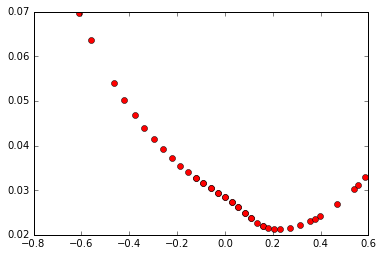

In [197]:
plt.plot(x_values[fut_contract], y_values[fut_contract], 'ro')

### № 2 [a Calibration - Skew]

In [207]:
def a_calibration(w0, key):
    
    def a_func(p, X):      
        a = p[0]    
        output = []
        for x in X:
            res = w0 + a*x
            output.append(res)        
        return output


    def err_a_func(p, X, Y):
        return (a_func(p, X) - Y)
    
    
    w_x_plus, w_x_minus = options_series[key].get_w_atm_opts()
    atm_opt_plus, atm_opt_minus = options_series[key].get_atm_opts()
    a_initial = (w_x_plus - w_x_minus) / (atm_opt_plus.x - atm_opt_minus.x)
    guess = np.array([a_initial])

    a_plus = (w_x_plus - w0) / (atm_opt_plus.x)
    a_minus = (w0 - w_x_minus) / (-atm_opt_minus.x)
    if a_minus >= a_plus:    
        bounds = ([-np.inf], [np.inf])
    else:
        bounds = ([a_minus], [a_plus])
        
    res = optimize.least_squares(fun=err_a_func, x0=guess, args=(x_values[key], y_values[key]), bounds=bounds)
    
    a_estimated = res.x
    
    x_values_new = []
    y_values_new = []


    for option in options_series[key].options.values():
        x_values_new.append(option.x)
        
    x_values_new = np.array(x_values_new)
    y_values_new = np.array(a_func(a_estimated, x_values_new))
    
    #print('a_estimated=%s' % a_estimated)  
    #plt.plot(x_values[key], y_values[key], 'ro', x_values_new, y_values_new)
    
    return a_estimated
    

### № 3 [b Calibration]

In [208]:
def b_calibration(w0, key, a_estimated):
    
    def b_func(p, X):      
        b = p[0] 
        output = []
        for x in X:        
            res = w0 + a_estimated[0]*x + b*(x**2)
            output.append(res)        
        return output

    def err_b_func(p, X, Y):
        return (b_func(p, X) - Y)
    
    w_x_plus, w_x_minus = options_series[key].get_w_atm_opts()
    atm_opt_plus, atm_opt_minus = options_series[key].get_atm_opts()
    b_initial = max((w_x_plus - 2*w0 + w_x_minus) / (atm_opt_plus.x - atm_opt_minus.x)**2, 0.0)
    guess = np.array([b_initial])
    bounds = ([0.0], [np.inf])
    
    res = optimize.least_squares(fun=err_b_func, x0=guess, args=(x_values[key], y_values[key]), bounds=bounds)
    
    b_estimated = res.x
    
    x_values_new = []
    y_values_new = []

    for option in options_series[key].options.values():
        x_values_new.append(option.x)
        
    x_values_new = np.array(x_values_new)
    y_values_new = np.array(b_func(b_estimated, x_values_new))
    
    sum_errors = sum(list(map(lambda x: x**2, res.fun)))
    
    #print('b_estimated=%s' % b_estimated)              
    #print('sum squared errors=%s' % sum_errors)
    
    y_diffs = y_values[key] - y_values_new
    
    
    
    #f, axarr = plt.subplots(2, figsize=(15, 10))
    #axarr[0].plot(x_values[key], y_values[key], 'r+', x_values_new, y_values_new, 'g+')
    #axarr[0].set_title('y, y_new')
    #axarr[1].plot(x_values_new, y_diffs, 'b+')
    #axarr[1].set_title('y - y_new')
    
    
    return b_estimated

### № 4 [a & b Calibration]

In [209]:
def ab_calibration(w0, key, a_estimated, b_estimated):
    
    def ab_func(p, X):      
        a, b = p    
        output = []
        for x in X:
            res = w0 + a*x + b*(x**2)
            output.append(res)        
        return output


    def err_ab_func(p, X, Y):
        return (ab_func(p, X) - Y)  
    
    guess = np.array([a_estimated[0], b_estimated[0]])
    bounds = ([-np.inf, 0.0], [np.inf, np.inf])
    
    res = optimize.least_squares(fun=err_ab_func, x0=guess, args=(x_values[key], y_values[key]), bounds=bounds)
    
    ab_estimated = res.x
    
    x_values_new = []
    y_values_new = []

    for option in options_series[key].options.values():
        x_values_new.append(option.x)
        
    x_values_new = np.array(x_values_new)
    y_values_new = np.array(ab_func(ab_estimated, x_values_new))
    
    sum_errors = sum(list(map(lambda x: x**2, res.fun)))
    
    print('ab_estimated=%s' % ab_estimated)              
    print('sum squared errors=%s' % sum_errors)
    print('\n')
        
    y_diffs = y_values[key] - y_values_new
    
    
    #f, axarr = plt.subplots(2, figsize=(15, 10))
    #axarr[0].plot(x_values[key], y_values[key], 'r+', x_values_new, y_values_new, 'g+')
    #axarr[0].set_title('y, y_new')
    #axarr[1].plot(x_values_new, y_diffs, 'b+')
    #axarr[1].set_title('y - y_new')
    
    
    return ab_estimated

### Условие № 5 (то самое)

In [210]:
def condition(w0, key, a_estimated, b_estimated, delta1, delta2, delta3):
    '''
    return True - идем дальше, по этапу
    return False - перескакиваем на 5.5
    '''

    def subsidiary_calculations():
        
        teta_initial = 0.0    
        guess = np.array([teta_initial])
        bounds = ([0.0], [min(w0, 4/b_estimated)])
            
        def subsidiary_func(p, X):      
            teta = p[0] 
            output = []
            for x in X:
                res = w0 - teta/2 + (a_estimated*x)/2 + np.sqrt(b_estimated*teta*x**2 + (teta**2) / 4)
                output.append(res)        
            return output
    
    
        def err_subsidiary_func(p, X, Y):
            return (subsidiary_func(p, X) - Y)
        
        res = optimize.least_squares(fun=err_subsidiary_func, x0=guess, args=(x_values[key], y_values[key]), bounds=bounds)
        teta_estimated = res.x[0]
        
        if teta_estimated < (4/b_estimated):
            phi = np.sqrt((4*b_estimated) / teta_estimated)
        else:
            phi = min(np.sqrt((4*b_estimated) / teta_estimated), (2 / np.sqrt(teta_estimated)))
            
        ro = 0.0
        return ro, phi, teta_estimated    
    
    
    if abs(a_estimated) <= delta1 and abs(b_estimated) <= delta2:
        if (abs(b_estimated/a_estimated) <= delta3):
            
            if a_estimated > 0:
                ro = 1
            else:
                ro = -1
            teta = phi = 0            
            #print('Переходим к пункту 5.5')
            #print('ro=%s \nphi=%s \nteta=%s' % (ro, phi, teta))
            return False, ro, phi, teta
            
            
        else:
            ro, phi, teta = subsidiary_calculations()
            #print('Переходим к пункту 5.5')
            #print('ro=%s \nphi=%s \nteta=%s' % (ro, phi, teta))
            return False, ro, phi, teta
    else:
        if abs(a_estimated) > delta1 and abs(b_estimated) <= delta2:
            if a_estimated > 0:
                ro = 1
            else:
                ro = -1
            teta = phi = 0
            #print('Переходим к пункту 5.5')
            #print('ro=%s \nphi=%s \nteta=%s' % (ro, phi, teta))
            return False, ro, phi, teta
            
        elif abs(a_estimated) <= delta1 and abs(b_estimated) > delta2:
            ro, phi, teta = subsidiary_calculations()
            #print('Переходим к пункту 5.5')
            #print('ro=%s \nphi=%s \nteta=%s' % (ro, phi, teta))
            return False, ro, phi, teta
        else:
            #print('Переходим к пункту 5.2')
            #print('ro=%s \nphi=%s \nteta=%s' % (ro, phi, teta))
            return True, True, True, True
            

### № 5.2 [Calculate c and d ]

In [211]:
def cd_calculation(a_estimated, b_estimated):
    
    if a_estimated > 0:
        
        if 0 < 1/(4/a_estimated - 1) <= 1 - b_estimated:
            c = 1/(4/a_estimated - 1)
            d = 1 - b_estimated
        else:
            c = 0
            d = 1
    else:
        if b_estimated - 1 <= 1/(4/a_estimated + 1) < 0:
            c = 1/(4/a_estimated + 1)
            d = b_estimated - 1
        else:
            c = 0
            d = -1
        
    return c, d

### № 5.3 [ro Calibration]

In [212]:
def ro_calibration(w0, key, a_estimated, b_estimated, c, d):
    
    def ro_func(p, X):      
        s = p[0]
        output = []
        for x in X:
            res = w0 + (a_estimated / 2)*x + \
            (((1 - s) / s) * ((a_estimated**2) / 8*b_estimated)) * \
            (np.sqrt(s*(((x*4*b_estimated / (a_estimated*(1-s))) + 1)**2) + 1 - s) - 1)
            
            output.append(res)        
        return output
    
    
    def err_ro_func(p, X, Y):
        return (ro_func(p, X) - Y) 
    
    s_initial = min(1, d**2)
    guess = np.array([s_initial])
    bounds = ([c**2], [min(1, d**2)])
    
    res = optimize.least_squares(fun=err_ro_func, x0=guess, args=(x_values[key], y_values[key]), bounds=bounds)
    
    s_estimated = res.x
    
  
    x_values_new = []
    y_values_new = []

    for option in options_series[key].options.values():
        x_values_new.append(option.x)
        
    x_values_new = np.array(x_values_new)
    y_values_new = np.array(ro_func(s_estimated, x_values_new))
    
    if a_estimated > 0:
        ro_initial = np.sqrt(s_estimated)
    else:
        ro_initial = -np.sqrt(s_estimated)
        
        
    sum_errors = sum(list(map(lambda x: x**2, res.fun)))    
    
    print('ro_initial=%s' % ro_initial)              
    print('sum squared errors=%s' % sum_errors)
    print('\n')
    
    y_diffs = y_values[key] - y_values_new
    
    
    #f, axarr = plt.subplots(2, figsize=(15, 10))
    #axarr[0].plot(x_values[key], y_values[key], 'r+', x_values_new, y_values_new, 'g+')
    #axarr[0].set_title('y, y_new')
    #axarr[1].plot(x_values_new, y_diffs, 'b+')
    #axarr[1].set_title('y - y_new')

    return ro_initial        

### № 5.4 alpha and beta Callibration

In [213]:
def alphabeta_calibration(w0, key, a_estimated, b_estimated, ro_initial):

    alpha_initial = a_estimated / ro_initial
    beta_initial = (4*b_estimated) / (1 - ro_initial**2)
    
    def alphabeta_func(p, X):
        alpha, beta, ro = p                
        output = []
        
        '''
        2) альфа стартовое min(...)
        
        '''
        
        if not(0 <= alpha < (4/(1+abs(ro))) and 0 <= beta <= (4/(1+abs(ro))) and alpha <= np.sqrt(w0*beta)):
            output.append(10**10) # Такая комбинация параметров нас не устраивает
            return output
        
        for x in X:
            res = w0 - ((alpha**2)/2*beta) + (alpha*ro*x)/2 + alpha/(2*beta)*\
            np.sqrt((beta*x+alpha*ro)**2 + (1-ro**2) * alpha**2)
            output.append(res)
        return output
    
    
    def err_alphabeta_func(p, X, Y):
        return (alphabeta_func(p, X) - Y)
    
    
    guess = np.array([min(4/(1.0+abs(ro_initial[0])), alpha_initial[0], np.sqrt(w0*beta_initial[0])), min(4/(1+abs(ro_initial[0])), beta_initial[0]), ro_initial[0]])
    if a_estimated > 0:
        bounds = ([-np.inf, -np.inf, 0.0], [np.inf, np.inf, 1.0])
    else:
        bounds = ([-np.inf, -np.inf, -1.0], [np.inf, np.inf, 0.0])
    
    res = optimize.least_squares(fun=err_alphabeta_func, x0=guess, args=(x_values[key], y_values[key]), bounds=bounds)
    
    alpha_estimated, beta_estimated, ro_estimated = res.x
    
    
    x_values_new = []
    y_values_new = []

    for option in options_series[key].options.values():
        x_values_new.append(option.x)
        
    x_values_new = np.array(x_values_new)
    y_values_new = np.array(alphabeta_func([alpha_estimated, beta_estimated, ro_estimated], x_values_new))
    
    sum_errors = sum(list(map(lambda x: x**2, res.fun)))
    
    print('alpha_estimated=%s \nbeta_estimated=%s \nro_estimated=%s' % (alpha_estimated, beta_estimated, ro_estimated))            
    print('sum squared errors=%s' % sum_errors)
    print('\n')
    
    y_diffs = y_values[key] - y_values_new
    
    
    #f, axarr = plt.subplots(2, figsize=(15, 10))
    #axarr[0].plot(x_values[key], y_values[key], 'r+', x_values_new, y_values_new, 'g+')
    #axarr[0].set_title('y, y_new')
    #axarr[1].plot(x_values_new, y_diffs, 'b+')
    #axarr[1].set_title('y - y_new')
    
    return alpha_estimated, beta_estimated, ro_estimated
    

### № 5.5 final

In [214]:
def final_calibration(w0, w0_prev, teta_initial, teta_prev, ro_initial, phi_initial):

    gamma_initial = 0.5        
    eta_initial = phi_initial*(teta_initial**gamma_initial)*((1+teta_initial)**(1-gamma_initial))
    
    def final_func(p, X):
        eta, teta, ro, gamma = p                
        output = []
        
        if not(eta*(1 + abs(ro)) <= 2):
            output.append(10**10) # Такая комбинация параметров нас не устраивает
            return output
        
        for x in X:
            phi = eta / ((teta**gamma)*(1+teta)**(1-gamma))
            res = w0 - teta/2 + (teta*ro*phi*x)/2 + (teta/2)*np.sqrt((phi*x + ro)**2 + 1 - ro**2)
    
            output.append(res)
        return output
    
    
    def err_final_func(p, X, Y):
        return (final_func(p, X) - Y)
    
    
    
    if np.isnan(teta_prev):
        bounds = ([0.0, 0.0, -1.0, 0.0], [np.inf, w0, 1.0, 1.0])
        guess = np.array([eta_initial, teta_initial, ro_initial, gamma_initial])
    else:
        bounds = ([0.0, teta_prev, -1.0, 0.0], [np.inf, max(teta_prev + 10**(-5), min(w0, (teta_prev + w0 - w0_prev))), 1.0, 1.0])
        guess = np.array([eta_initial, teta_prev, ro_initial, gamma_initial])
        
    
    res = optimize.least_squares(fun=err_final_func, x0=guess, args=(x_values[key], y_values[key]), bounds=bounds)
    
    eta_estimated, teta_estimated, ro_estimated, gamma_estimated = res.x
    
    
    
    
    x_values_new = []
    y_values_new = []

    for option in options_series[key].options.values():
        x_values_new.append(option.x)
        
    x_values_new = np.array(x_values_new)
    y_values_new = np.array(final_func([eta_estimated, teta_estimated, ro_estimated, gamma_estimated], x_values_new))
    
    sum_errors = sum(list(map(lambda x: x**2, res.fun)))
    
    print('eta_estimated=%s \nteta_estimated=%s \nro_estimated=%s \ngamma_estimated=%s' % (eta_estimated, teta_estimated, ro_estimated, gamma_estimated))           
    print('sum squared errors=%s' % sum_errors)
    print('\n')
    
    y_diffs = y_values[key] - y_values_new
    
    
   
    #f, axarr = plt.subplots(2, figsize=(15, 10))
    #axarr[0].plot(x_values[key], y_values[key], 'r+', x_values_new, y_values_new, 'g+')
    #axarr[0].set_title('y, y_new')
    #axarr[1].plot(x_values_new, y_diffs, 'b+')
    #axarr[1].set_title('y - y_new')
    
    return eta_estimated, teta_estimated, ro_estimated, gamma_estimated
    

In [215]:
w0_prev = np.nan
teta_prev = np.nan
times = []
w0s = []

output_params = []


for key in fut_contracts:
    w0 = options_series[key].get_w0()      
    a_estimated = a_calibration(w0, key)
    b_estimated = b_calibration(w0, key, a_estimated)
    a_estimated, b_estimated = ab_calibration(w0, key, a_estimated, b_estimated)
    delta1 = delta2 = delta3 = 0.01
    res, ro_initial, phi_initial, teta_initial = condition(w0, key, a_estimated, b_estimated, delta1, delta2, delta3)
    
    if res:
        c, d = cd_calculation(a_estimated, b_estimated)
        ro_initial = ro_calibration(w0, key, a_estimated, b_estimated, c, d)
        alpha_estimated, beta_estimated, ro_estimated = alphabeta_calibration(w0, key, a_estimated, b_estimated, ro_initial)
    
        phi_initial = beta_estimated
        teta_initial = (alpha_estimated**2) / beta_estimated
        ro_initial = ro_estimated
        
    eta_estimated, teta_estimated, ro_estimated, gamma_estimated = final_calibration(w0, w0_prev, teta_initial, teta_prev, ro_initial, phi_initial)
    
    w0s.append(w0)
    w0_prev = w0
    teta_prev = teta_estimated    
    times.append(options_series[key].get_t_series())
    output_params.append((eta_estimated, teta_estimated, ro_estimated, gamma_estimated))
    
    

ab_estimated=[-0.03098987  0.05726941]
sum squared errors=0.000114986363751


ro_initial=[-0.00780971]
sum squared errors=0.00332191169747


alpha_estimated=0.0744095493329 
beta_estimated=1.65399704554 
ro_estimated=-0.744480953378
sum squared errors=0.000276896990166


eta_estimated=0.716343203651 
teta_estimated=0.0284077588682 
ro_estimated=-0.401498318893 
gamma_estimated=0.448790133272
sum squared errors=0.000170390460994




In [126]:
etas = list(map(lambda x: x[0], output_params))
tetas = list(map(lambda x: x[1], output_params))
ros = list(map(lambda x: x[2], output_params))
gammas = list(map(lambda x: x[3], output_params))

In [127]:
p_estimated = [etas[0], tetas[0], ros[0], gammas[0]]

In [128]:
def final_func(p, X):
        eta, teta, ro, gamma = p                
        output = []
        
        if not(eta*(1 + abs(ro)) <= 2):
            output.append(10**10) # Такая комбинация параметров нас не устраивает
            return output
        
        for x in X:
            phi = eta / ((teta**gamma)*(1+teta)**(1-gamma))
            res = w0 - teta/2 + (teta*ro*phi*x)/2 + (teta/2)*np.sqrt((phi*x + ro)**2 + 1 - ro**2)
    
            output.append(res)
        return output

In [129]:
ys_new = final_func(p_estimated, x_values[fut_contract])

In [130]:
ys_new_norm = list(map(lambda x: np.sqrt(x/options_series[fut_contract].get_t_series()), ys_new))

In [131]:
y_values_norm = list(map(lambda x: np.sqrt(x/options_series[fut_contract].get_t_series()), y_values[fut_contract]))

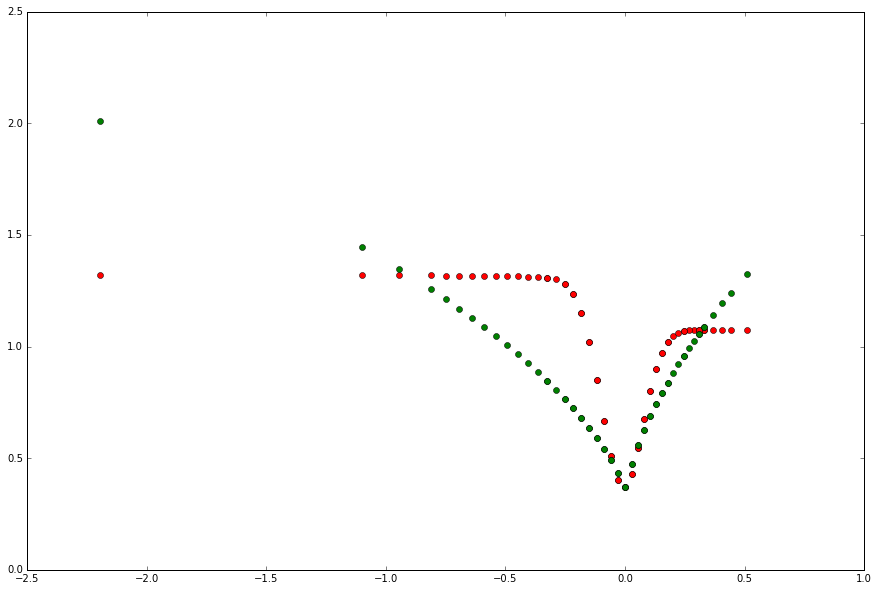

In [132]:
plt.figure(num=None, figsize=(15, 10), dpi=500, facecolor='w', edgecolor='k')
plt.plot(x_values[fut_contract], y_values_norm, 'ro', x_values[fut_contract], ys_new_norm, 'go')

In [ ]:
max_diff = 0.0
max_index = 0.0
for i in range(len(y_values_norm)):
    if abs(y_values_norm[i] - ys_new_norm[i])*100.0 > max_diff:
        max_diff = abs(y_values_norm[i] - ys_new_norm[i])*100.0
        max_index = i
    

In [ ]:
max_diff

In [ ]:
max_index

In [ ]:
y_values_norm[5]

In [ ]:
ys_new_norm[5]

In [ ]:
x_values[fut_contract][5]

In [ ]:
def ab_func(p, X):      
        a, b = p    
        output = []
        for x in X:
            res = w0 + a*x + b*(x**2)
            output.append(res)        
        return output

In [ ]:
xs_new = np.arange(-0.3, 0.6, 0.01)

In [ ]:
ys_new = ab_func([-0.04406356,  0.08808415], xs_new)

In [ ]:
plt.plot(x_values[fut_contract], y_values[fut_contract], 'ro', xs_new, ys_new, 'g-')

In [ ]:
fut_contract

In [ ]:
plt.figure(num=None, figsize=(15, 10), dpi=500, facecolor='w', edgecolor='k')
plt.title('RTS-9.16 [[eta= 0.6297, tetta= 0.0199, ro= -0.5077, gamma= 0.4623]')
plt.plot(x_values[fut_contract], y_values[fut_contract], 'ro', xs_new, ys_new, 'g-')
plt.savefig('RTS-9.16.png')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

n_angles = 36
n_radii = 8

# An array of radii
# Does not include radius r=0, this is to eliminate duplicate points
radii = np.linspace(0.125, 1.0, n_radii)

# An array of angles
angles = np.linspace(0, 2*np.pi, n_angles, endpoint=False)

# Repeat all angles for each radius
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)

# Convert polar (radii, angles) coords to cartesian (x, y) coords
# (0, 0) is added here. There are no duplicate points in the (x, y) plane
x = np.append(0, (radii*np.cos(angles)).flatten())
y = np.append(0, (radii*np.sin(angles)).flatten())

# Pringle surface
z = np.sin(-x*y)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.2)

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(-1.01, 1.01)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
options_series['RTS-9.16'].get_t_series()

### Call Interpolation

In [ ]:
def get_teta(t, tetas, times):
    '''
    Находим ближайшие t(j) и t(j+1),
    а точнее их индексы в списке
    '''
    next_t = prev_t = np.nan

    if t <= times[0]:
        return tetas[0]
    elif t >= times[-1]:
        return tetas[-1]
    else:        
        for index in range(len(times)):
            if t == times[index]: 
                return tetas[index]
            
            elif t < times[index]:
                next_t = index
                prev_t = index - 1                
                break
                
         
    teta_t =  tetas[prev_t] + (tetas[next_t] - tetas[prev_t]) * ((t - times[prev_t]) / (times[next_t] - times[prev_t]))
    
    return teta_t

In [ ]:
def get_alpha(t, tetas, times):
    '''
    Находим ближайшие t(j) и t(j+1),
    а точнее их индексы в списке
    '''
    next_t = prev_t = np.nan

    if t <= times[0]:
        return 0.0
    elif t >= times[-1]:
        return 1.0
    else:        
        for index in range(len(times)):
            if t == times[index]: 
                return 1.0
            
            elif t < times[index]:
                next_t = index
                prev_t = index - 1                
                break
    
    teta_t = get_teta(t, tetas, times)
    teta_t_prev = get_teta(times[prev_t], tetas, times)
    teta_t_next = get_teta(times[next_t], tetas, times)
    
    # Игорь сказал возвращать единичку
    if (teta_t_next - teta_t == 0) or (teta_t_next - teta_t_prev == 0):
        return 1.0
    
    alpha_t = ((np.sqrt(teta_t_next) - np.sqrt(teta_t)) / (np.sqrt(teta_t_next) - np.sqrt(teta_t_prev)))
    return alpha_t
    

In [ ]:
def get_F(t, times, R=0.01):
    '''
    Так как у нас пока нет кривой
    фючерсных цен, используем магию
    R - некий параметр.
    '''
    
    if t in times:
        return F[times.index(t)]
    elif t < times[0]:
        return F[0]*np.exp(R*(t - times[0]))     
    elif t > times[-1]:
        return F[-1]*np.exp(R*(t - times[-1]))      
    else:
        for index in range(len(times)):            
            if t < times[index]:
                next_t = index
                prev_t = index - 1                
                break
                
        return F[prev_t]*np.exp(R*(t - times[prev_t]))                    

In [ ]:
def get_w_from_calibrated_smile(x, t):
    '''
    Считаем w(x, t) - по новой улыбке.
    Пока предполагаем, что лучшей 
    оказалась последняя формула.
    '''
    # t - может быть только заданным
    index = times.index(t)
    
    
    # Нужно достать параметры для данной улыбки    
    eta, teta, ro, gamma = output_params[index]
    
    w0 = w0s[index]
    
    phi = eta / ((teta**gamma)*(1+teta)**(1-gamma))
    w = w0 - teta/2 + (teta*ro*phi*x)/2 + (teta/2)*np.sqrt((phi*x + ro)**2 + 1 - ro**2)
    
    return w

In [ ]:
def get_call_price(t, tetas, times, x0):
    '''
    Считаем цену колла
    '''
    
    def get_call_price_from_fix_t(t, x0):
            
        # Для опционов кратных t 
        index = times.index(t)
        
        F_t = F[index]        
        w = get_w_from_calibrated_smile(x0, t)        
        d_plus = -x0 / np.sqrt(w) + np.sqrt(w) / 2
        d_minus = -x0 / np.sqrt(w) - np.sqrt(w) / 2        
        call_price = F_t * norm.cdf(d_plus) - F_t * np.exp(x0) * norm.cdf(d_minus)
        return call_price
    
    if t in times:
        return get_call_price_from_fix_t(t, x0)

    '''
    Находим ближайшие t(j) и t(j+1),
    а точнее их индексы в списке
    '''
    next_t = prev_t = np.nan

    if t < times[0]:
        return get_call_price_from_fix_t(times[0], x0) / (F[0] * np.exp(x0))
    elif t > times[-1]:
        return get_call_price_from_fix_t(times[-1], x0) / (F[-1] * np.exp(x0))
    else:        
        for index in range(len(times)):
            if t == times[index]: 
                return 1.0            
            elif t < times[index]:
                next_t = index
                prev_t = index - 1                
                break
                
    call_price_prev_t = get_call_price_from_fix_t(times[prev_t], x0)
    call_price_next_t = get_call_price_from_fix_t(times[next_t], x0)
    
    K_t = get_F(t, times)*np.exp(x0)
    K_prev_t = F[prev_t]*np.exp(x0)
    K_next_t = F[next_t]*np.exp(x0)
    alpha_t = get_alpha(t, tetas, times)
    
    call_price_t = K_t * ((call_price_prev_t / K_prev_t) * alpha_t + (1 - alpha_t) * (call_price_next_t / K_next_t))
    return call_price_t

In [ ]:
ys = list(map(lambda x: get_call_price(1.0, tetas, times, x), x_values['FUT_1']))

In [ ]:
plt.plot(x_values['FUT_1'], ys, 'ro')

In [ ]:
def optimize_w(t, x0, times, delta_min, delta_max):
        
    def w_func(p, X):
        w = p[0]           
        output = []
                        
        for x in X:            
            F_t = get_F(t, times)                         
            d_plus = -x0 / np.sqrt(w) + (np.sqrt(w) / 2)
            d_minus = -x0 / np.sqrt(w) - (np.sqrt(w) / 2)        
            call_price = F_t * norm.cdf(d_plus) - F_t * np.exp(x0) * norm.cdf(d_minus)     
            output.append(call_price)
        return output
    
    
    def err_w_func(p, X, Y):
        return (w_func(p, X) - Y)
    
    
    # TODO:
    # Нужно найти t(j) и t(j+1)
    # и в зависимости от этого скорректировать 
    # bounds b guess
    
    
    
    '''
    Находим ближайшие t(j) и t(j+1),
    а точнее их индексы в списке
    
        
    next_t = prev_t = np.nan

    if t <= times[0]:
        bounds = ([delta_min], [get_w_from_calibrated_smile(x0, times[0])])
        guess = np.array([delta_min])
    elif t >= times[-1]:
        bounds = ([get_w_from_calibrated_smile(x0, times[-1])], [delta_max])
        guess = np.array([get_w_from_calibrated_smile(x0, times[-1])])
    else:        
        for index in range(len(times)):
            if t == times[index]: 
                return 1.0            
            elif t < times[index]:
                next_t = index
                prev_t = index - 1                
                break
                
        print(get_w_from_calibrated_smile(x0, times[prev_t]), get_w_from_calibrated_smile(x0, times[next_t]))        
        bounds = ([get_w_from_calibrated_smile(x0, times[prev_t])], [get_w_from_calibrated_smile(x0, times[next_t])])
        guess = np.array([get_w_from_calibrated_smile(x0, times[prev_t])])
    
    '''
    
    
    bounds = ([delta_min], [delta_max])
    guess = np.array([delta_min])
    
    xs = np.array([x0])
    ys = np.array([get_call_price(t, tetas, times, x0)])
    
    res = optimize.least_squares(fun=err_w_func, x0=guess, args=(xs, ys), bounds=bounds)
    
    w_estimated = res.x
    return w_estimated

### Error Analysis

In [ ]:
xs = np.arange(-5.0, 5.0, 0.1)
ys = []

t = 2.0
for x in xs:
    w_opt = optimize_w(t=t, x0=x, times=times, delta_min=0.05, delta_max=100.0)
    w = w_opt
    F_t = get_F(t, times)               
    d_plus = -x / np.sqrt(w) + (np.sqrt(w) / 2)
    d_minus = -x / np.sqrt(w) - (np.sqrt(w) / 2)        
    call_price = F_t * norm.cdf(d_plus) - F_t * np.exp(x) * norm.cdf(d_minus)        
    call_price_old = get_call_price(t=t, tetas=tetas, times=times, x0=x)      
    ys.append(call_price - call_price_old)

In [ ]:
plt.figure(num=None, figsize=(15, 6), dpi=100, facecolor='w', edgecolor='k')
plt.title('Kalenkovych Points')
plt.plot(xs, ys, 'ro')